In [193]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm

In [2]:
def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params

In [3]:
params = initialize_random_params()

In [4]:
params

{'phi': 0.7987012626117604,
 'mu0': array([-1.25529633,  1.19188651]),
 'mu1': array([-0.49233921, -0.06333992]),
 'sigma0': array([[1.8450409 , 0.70832431],
        [0.70832431, 0.59132029]]),
 'sigma1': array([[2.1552165 , 0.74829504],
        [0.74829504, 1.13175248]])}

In [ ]:
x_unlabeled=

In [5]:
#%load_ext autoreload
#%autoreload 2


import sys
sys.path.append("../../mrf-sim/")
sys.path.append("../../epgpy/")
sys.path.append("../../machines/")
sys.path.append("../../mutools/")
sys.path.append("../../dicomstack/")

#import matplotlib
#matplotlib.use("TkAgg")
from mrfsim import T1MRF
from image_series import *
from utils_mrf import regression_paramMaps_ROI,buildROImask,plot_evolution_params,compare_paramMaps
import json
from finufft import nufft1d1,nufft1d2
from scipy import signal,interpolate
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
from movements import *
from dictoptimizers import *

%matplotlib inline

In [6]:
FF_list=list(np.arange(0.,1.05,0.05))

In [8]:
dict_file=r"../mrf175_SimReco2.dict"
keys,signals = read_mrf_dict(dict_file ,FF_list ,aggregate_components=True)

In [11]:
len(keys)

323190

In [45]:
X = np.array(np.delete(keys,1,1))

In [46]:
X.shape

(323190, 4)

In [18]:
Y=np.array(signals)

In [19]:
Y.shape

(323190, 175)

In [47]:
X_Y=np.concatenate([X,Y],axis=-1)
mu_X_Y = X_Y.mean(axis=0)
sig_X_Y = X_Y.std(axis=0)

In [48]:
X_Y_normalized = (X_Y - mu_X_Y)/sig_X_Y

In [192]:
def pdf_multivarial_normal(x,mean,cov,hermitian=False):
    d=mean.shape[0]
    pinv_conv = np.linalg.pinv(cov,hermitian)
    
    eig_values,_ = np.linalg.eig(cov)
    pseudo_det = np.product(eig_values[eig_values > 1e-12])
    return (pseudo_det * 2*np.pi)**(-1/2)*np.exp(-0.5*np.sum((x-mean).conj()*((x-mean)@pinv_conv.T),axis=1))
    


In [185]:
x1=np.arange(0,20,0.5)
x2=np.array([0.]*x1.shape[0])
x=np.vstack( [x1,x2]).T
cov=np.array([[1,0],[0,0]])
mean=np.array([0,0])
res=pdf_multivarial_normal(x,mean,cov)

[1. 0.]


In [187]:
res

array([3.98942280e-01, 3.52065327e-01, 2.41970725e-01, 1.29517596e-01,
       5.39909665e-02, 1.75283005e-02, 4.43184841e-03, 8.72682695e-04,
       1.33830226e-04, 1.59837411e-05, 1.48671951e-06, 1.07697600e-07,
       6.07588285e-09, 2.66955661e-10, 9.13472041e-12, 2.43432053e-13,
       5.05227108e-15, 8.16623563e-17, 1.02797736e-18, 1.00779354e-20,
       7.69459863e-23, 4.57537559e-25, 2.11881925e-27, 7.64165541e-30,
       2.14638374e-32, 4.69519536e-35, 7.99882776e-38, 1.06126881e-40,
       1.09660656e-43, 8.82475497e-47, 5.53070955e-50, 2.69951302e-53,
       1.02616307e-56, 3.03790170e-60, 7.00418213e-64, 1.25767238e-67,
       1.75874954e-71, 1.91543249e-75, 1.62463604e-79, 1.07317783e-83])

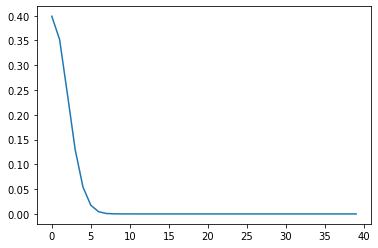

In [188]:
plt.plot(res)

In [147]:
(pinvc@(x-mean).T).shape

(40,)

In [203]:


class GMM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components),dtype=np.complex128)

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components,dtype=np.complex128)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False),dtype=np.complex128)

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in tqdm(range(self.n_iters)):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            print(log_likelihood_new)
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        print("Expectation Step")
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in tqdm(range(self.n_components)):
            prior = self.weights[k]
            likelihood = pdf_multivarial_normal(X,self.means[k], self.covs[k],hermitian=True)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""
        print("Maximization Step")
        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self



In [204]:
gmm = GMM(n_components = 20, n_iters = 10, tol = 1e-4, seed = 4)

In [205]:
np.linalg.matrix_rank(gmm.covs[0])

AttributeError: 'GMM' object has no attribute 'covs'

In [206]:
gmm.fit(X_Y)

  0%|          | 0/10 [00:00<?, ?it/s]

Expectation Step



100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Maximization Step


 10%|█         | 1/10 [00:35<05:17, 35.27s/it]

(60027462.939819284+0.0051109131702578j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Maximization Step


 20%|██        | 2/10 [01:10<04:44, 35.50s/it]

(32649902.19093457-150351.98295989932j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Maximization Step


 30%|███       | 3/10 [01:46<04:09, 35.65s/it]

(32649902.193567347-150351.98438618938j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Maximization Step


 40%|████      | 4/10 [02:22<03:33, 35.64s/it]

(32649902.1873157-150351.98620767385j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Maximization Step


 50%|█████     | 5/10 [02:57<02:57, 35.58s/it]

(32649902.190793775-150351.98286486536j)
Expectation Step



100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Maximization Step


 60%|██████    | 6/10 [03:32<02:21, 35.40s/it]

(32649902.19093457-150351.98295989932j)
Expectation Step



100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Maximization Step


 70%|███████   | 7/10 [04:07<01:45, 35.27s/it]

(32649902.193567347-150351.98438618938j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Maximization Step


 80%|████████  | 8/10 [04:43<01:10, 35.50s/it]

(32649902.1873157-150351.98620767385j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Maximization Step


 90%|█████████ | 9/10 [05:20<00:35, 35.69s/it]

(32649902.190793775-150351.98286486536j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Maximization Step


100%|██████████| 10/10 [05:56<00:00, 35.63s/it]

(32649902.19093457-150351.98295989932j)


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


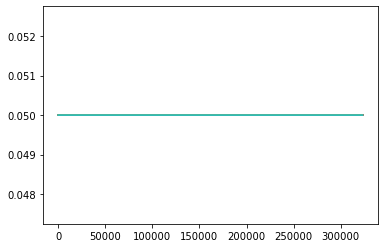

In [208]:
plt.plot(gmm.resp)

In [171]:
X_Y.shape

(323190, 179)

In [79]:
gmm.means.shape

(100, 179)

In [80]:
gmm.covs.shape

(100, 179, 179)

In [81]:
gmm.means

array([[ 6.80000000e+02+0.j        ,  3.50000000e-01+0.j        ,
        -6.00000000e-02+0.j        , ...,  6.40021174e-03-0.01241383j,
         6.40061297e-03-0.01245161j,  6.40050396e-03-0.01248644j],
       [ 6.20000000e+02+0.j        ,  7.00000000e-01+0.j        ,
         3.00000000e-02+0.j        , ...,  1.73445217e-02+0.02940641j,
         1.74981096e-02+0.02960429j,  1.76388961e-02+0.02978462j],
       [ 1.44000000e+03+0.j        ,  9.50000000e-01+0.j        ,
        -6.00000000e-02+0.j        , ...,  2.41303619e-02-0.01835263j,
         2.41687327e-02-0.0184066j ,  2.42002797e-02-0.01845428j],
       ...,
       [ 1.25000000e+03+0.j        ,  6.00000000e-01+0.j        ,
        -0.00000000e+00+0.j        , ...,  2.29217566e-02+0.00493044j,
         2.32192392e-02+0.00493805j,  2.35024611e-02+0.0049445j ],
       [ 7.20000000e+02+0.j        ,  8.00000000e-01+0.j        ,
         4.50000000e-02+0.j        , ..., -1.86857386e-03+0.03164324j,
        -1.81949397e-03+0.03189482j

In [82]:
gmm.covs

array([[[ 1.24679864e+05+0.00000000e+00j,
         -3.97129520e-14+0.00000000e+00j,
          1.54776953e-17+0.00000000e+00j, ...,
         -4.03932282e-01-3.58801118e-17j,
         -4.01699081e-01-7.73884764e-18j,
         -3.99225461e-01+1.51259295e-17j],
        [-3.97129520e-14+0.00000000e+00j,
          4.66668111e-02+0.00000000e+00j,
         -7.38570775e-20+0.00000000e+00j, ...,
          4.38899041e-04-3.00457611e-04j,
          4.45268080e-04-3.01198840e-04j,
          4.51094083e-04-3.01813685e-04j],
        [ 1.54776953e-17+0.00000000e+00j,
         -7.38570775e-20+0.00000000e+00j,
          1.50000464e-03+0.00000000e+00j, ...,
         -3.02636703e-04-5.82581806e-04j,
         -3.03105275e-04-5.87942678e-04j,
         -3.03499933e-04-5.92965736e-04j],
        ...,
        [-4.03932282e-01+3.58801118e-17j,
          4.38899041e-04+3.00457611e-04j,
         -3.02636703e-04+5.82581806e-04j, ...,
          5.08688975e-04+0.00000000e+00j,
          5.12627024e-04+7.39647930e-07j

In [83]:
np.min(np.abs(X_Y))

0.0

In [84]:
gmm.weights

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [85]:
multivariate_normal(gmm.means[0],gmm.covs[0])

LinAlgError: singular matrix

In [86]:
np.all(np.linalg.eigvals(gmm.covs[0]) > 0)

False

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


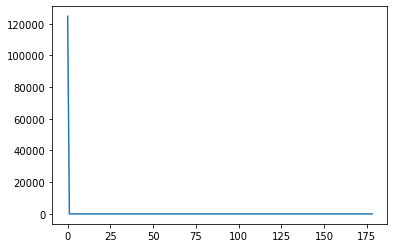

In [88]:
plt.plot(np.linalg.eigvals(gmm.covs[1]))